In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from scipy.stats import norm

# ===== PARAMETERS =====
TIME_INTERVAL = "1h"  # Can be '5min', '15min', '1h', etc.
INTERVAL_MINUTES = 60  # Minutes corresponding to TIME_INTERVAL
VOLATILITY_WINDOW = 60  # Rolling window for volatility calculation
# Start date for data fetching must be at most 8 days ago
START_DATE = datetime.datetime.now(tz=datetime.UTC) - datetime.timedelta(days=7)

# Trading Parameters
TRADE_THRESHOLD = 0.95  # Only trade when model probability > this threshold
COST_PER_TRADE = 0.50  # Cost to enter a trade (in dollars)
WIN_AMOUNT = 1.00  # Payout for correct prediction (in dollars)
# =====================

# BTC Up/Down Market Backtester

**Configuration Parameters** (edit cell 1 to change):
- Time Interval: `5min` (change to `15min`, `1h`, etc.)
- Volatility Window: `5` minutes
- Start Date: `2026-02-15`

Run all cells sequentially to perform the analysis.

In [2]:
btc_data = yf.download("BTC-USD", start=START_DATE, interval="1m", group_by="ticker")["BTC-USD"]
btc_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Datetime,,,,,
2026-02-15 04:55:00+00:00,70155.023438,70155.023438,70155.023438,70155.023438,0
2026-02-15 04:56:00+00:00,70113.101562,70113.101562,70113.101562,70113.101562,2957312
2026-02-15 04:57:00+00:00,70142.859375,70142.859375,70142.859375,70142.859375,2473984
2026-02-15 04:58:00+00:00,70117.976562,70117.976562,70117.976562,70117.976562,0
2026-02-15 04:59:00+00:00,70130.523438,70130.523438,70130.523438,70130.523438,1585152


In [3]:
# Group by time interval and calculate start/end prices
btc_data["Start"] = btc_data.groupby(pd.Grouper(freq=TIME_INTERVAL))["Close"].transform("first")
btc_data["End"] = btc_data.groupby(pd.Grouper(freq=TIME_INTERVAL))["Close"].transform("last")

# Calculate time remaining in minutes until the next interval
btc_data["Time_Remaining"] = (
    INTERVAL_MINUTES - (btc_data.index.minute % INTERVAL_MINUTES) - (btc_data.index.second / 60)
)

# Calculate log returns and volatility
btc_data["Log_returns"] = np.log(btc_data["Close"] / btc_data["Close"].shift(1)).dropna()
btc_data["Volatility"] = btc_data["Log_returns"].rolling(window=VOLATILITY_WINDOW).std() * np.sqrt(
    VOLATILITY_WINDOW
)

# Drop NaN values
btc_data = btc_data.dropna()

# Exclude final minute of each interval (when time_remaining < 1) to avoid lookahead bias
btc_data = btc_data[btc_data["Time_Remaining"] > 1.0]

# Calculate distance from start price
btc_data["Distance"] = np.log(btc_data["Close"] / btc_data["Start"])

print(f"Time Interval: {TIME_INTERVAL}")
print(f"Data shape: {btc_data.shape}")
btc_data.head()

Time Interval: 1h
Data shape: (9004, 11)


Price,Open,High,Low,Close,Volume,Start,End,Time_Remaining,Log_returns,Volatility,Distance
Datetime,,,,,,,,,,,
2026-02-15 05:55:00+00:00,70303.179688,70303.179688,70303.179688,70303.179688,31109120,70159.1875,70265.632812,5.0,-0.000333,0.003944,0.002050
2026-02-15 05:56:00+00:00,70261.843750,70261.843750,70261.843750,70261.843750,0,70159.1875,70265.632812,4.0,-0.000588,0.003942,0.001462
2026-02-15 05:57:00+00:00,70269.976562,70269.976562,70269.976562,70269.976562,0,70159.1875,70265.632812,3.0,0.000116,0.003923,0.001578
2026-02-15 05:58:00+00:00,70267.757812,70267.757812,70267.757812,70267.757812,37703680,70159.1875,70265.632812,2.0,-0.000032,0.003904,0.001546
2026-02-15 06:00:00+00:00,70249.375000,70249.375000,70249.375000,70249.375000,0,70249.3750,70372.929688,60.0,-0.000231,0.003892,0.000000


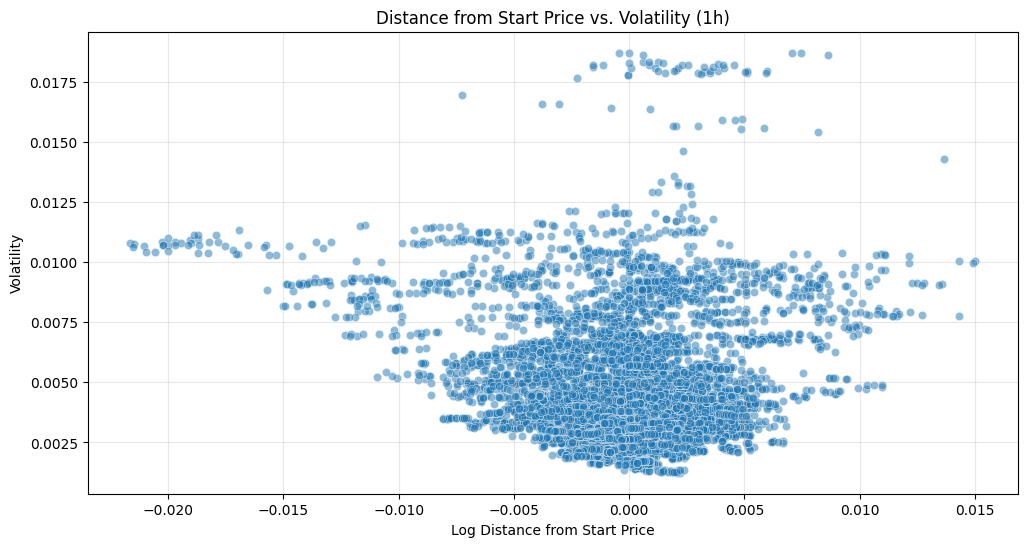

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x="Distance", y="Volatility", data=btc_data, alpha=0.5)
plt.title(f"Distance from Start Price vs. Volatility ({TIME_INTERVAL})")
plt.xlabel("Log Distance from Start Price")
plt.ylabel("Volatility")
plt.grid(visible=True, alpha=0.3)
plt.show()

In [5]:
def calculate_model_prob(distance: float, volatility: float, time_remaining: float) -> float:
    """
    Calculate probability of UP movement using log-normal model.

    Args:
        distance: log return from start price
        volatility: annualized volatility
        time_remaining: time remaining in minutes
    """
    # Normalize time remaining by interval minutes
    delta_t = time_remaining / INTERVAL_MINUTES
    denom = volatility * np.sqrt(delta_t)

    if denom == 0:
        return 0.5

    z = -distance / denom
    prob_up = 1 - norm.cdf(z)

    return prob_up

In [6]:
btc_data["Prob_Up"] = btc_data.apply(
    lambda row: calculate_model_prob(row["Distance"], row["Volatility"], row["Time_Remaining"]),
    axis=1,
)

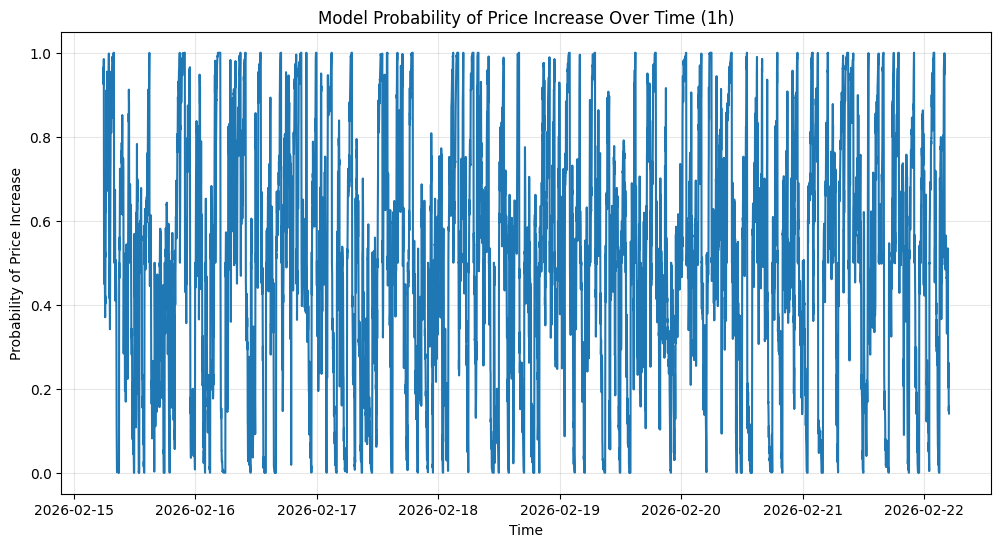

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=btc_data.index, y="Prob_Up", data=btc_data)
plt.title(f"Model Probability of Price Increase Over Time ({TIME_INTERVAL})")
plt.xlabel("Time")
plt.ylabel("Probability of Price Increase")
plt.grid(visible=True, alpha=0.3)
plt.show()


Calibration Analysis (1h):
Price      Actual_Up       Prob_Up
                mean count    mean
Prob_Bin                          
(0.0, 0.2]     0.060  1620   0.070
(0.2, 0.4]     0.293  1377   0.306
(0.4, 0.6]     0.564  2623   0.507
(0.6, 0.8]     0.700  1705   0.687
(0.8, 1.0]     0.946  1670   0.927


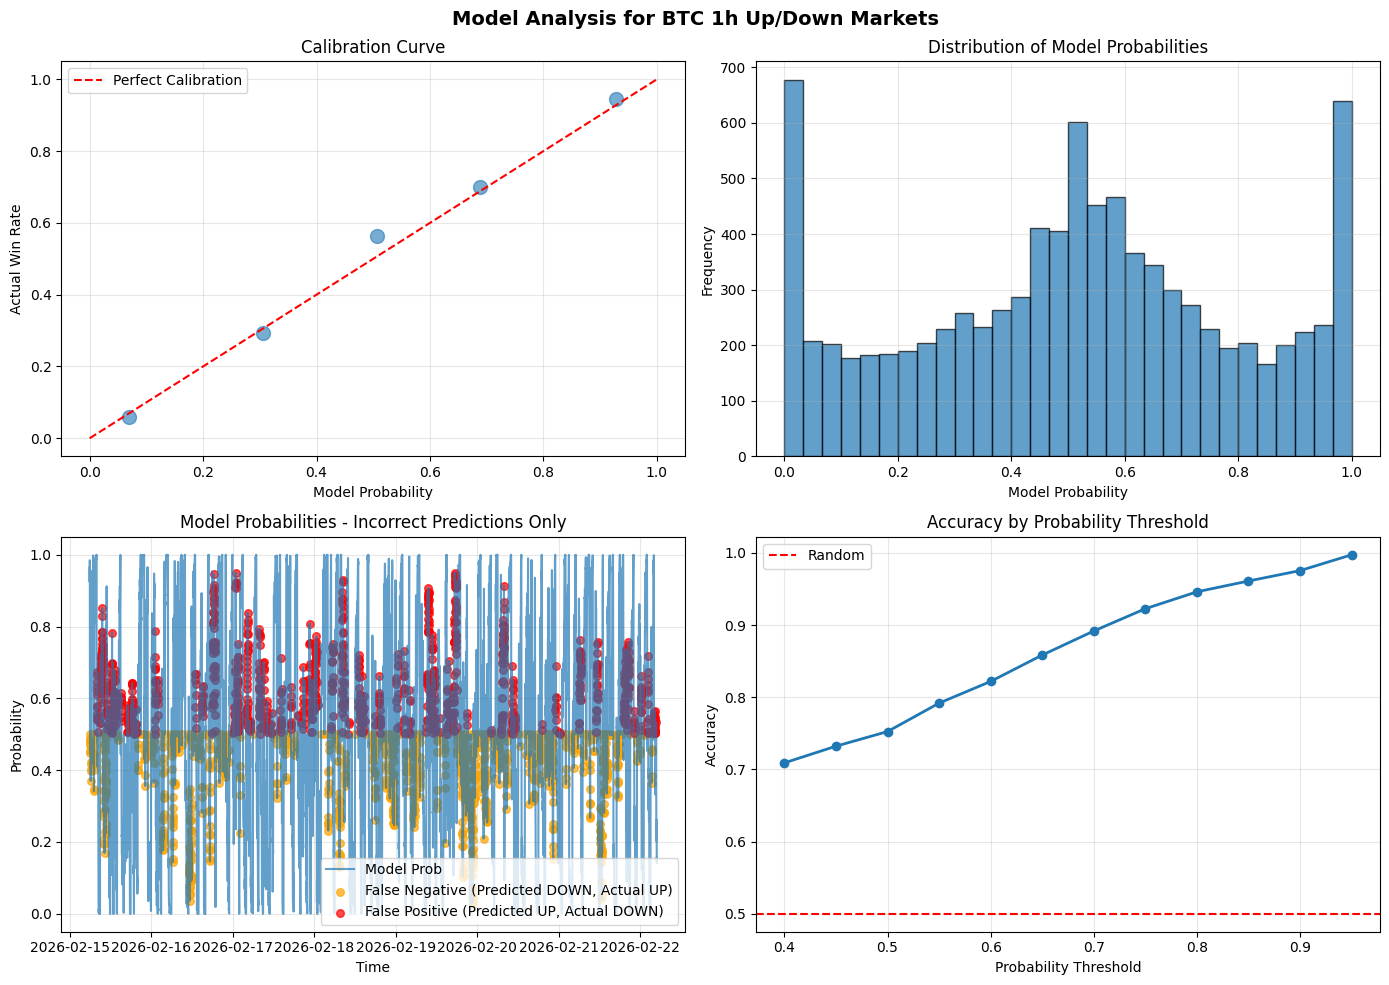


Model Statistics (1h):
Average Model Prob: 0.509
Actual UP Rate: 0.528
Overall Accuracy (>0.5 threshold):     0.745
Total samples: 9004
False Positives: 1134
False Negatives: 1160


In [8]:
# Create actual outcome column (1 = price went UP, 0 = price went DOWN)
# Based on the price at the END of the interval vs START
btc_data["Actual_Up"] = (btc_data["End"] > btc_data["Start"]).astype(int)

# Create probability bins to compare calibration
btc_data["Prob_Bin"] = pd.cut(btc_data["Prob_Up"], bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0])

# Calculate actual win rate for each probability bin
calibration = (
    btc_data.groupby("Prob_Bin", observed=True)
    .agg({"Actual_Up": ["mean", "count"], "Prob_Up": "mean"})
    .round(3)
)

print(f"\nCalibration Analysis ({TIME_INTERVAL}):")
print(calibration)

# Visualization: Model Calibration and Performance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    f"Model Analysis for BTC {TIME_INTERVAL} Up/Down Markets", fontsize=14, fontweight="bold"
)

# Plot 1: Calibration curve
ax1 = axes[0, 0]
prob_bins = (
    btc_data.groupby("Prob_Bin", observed=True)
    .agg({"Prob_Up": "mean", "Actual_Up": "mean"})
    .reset_index(drop=True)
)

ax1.scatter(prob_bins["Prob_Up"], prob_bins["Actual_Up"], s=100, alpha=0.6)
ax1.plot([0, 1], [0, 1], "r--", label="Perfect Calibration")
ax1.set_xlabel("Model Probability")
ax1.set_ylabel("Actual Win Rate")
ax1.set_title("Calibration Curve")
ax1.legend()
ax1.grid(visible=True, alpha=0.3)

# Plot 2: Model Probability Distribution
ax2 = axes[0, 1]
ax2.hist(btc_data["Prob_Up"], bins=30, alpha=0.7, edgecolor="black")
ax2.set_xlabel("Model Probability")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Model Probabilities")
ax2.grid(visible=True, alpha=0.3)

# Plot 3: Time series of probabilities vs outcome (INCORRECT PREDICTIONS ONLY)
ax3 = axes[1, 0]
ax3.plot(btc_data.index, btc_data["Prob_Up"], label="Model Prob", alpha=0.7)

# False Negatives: Model predicted DOWN (Prob <= 0.5) but actual was UP
UP_DOWN_THRESHOLD = 0.5
false_negatives = btc_data[(btc_data["Prob_Up"] <= UP_DOWN_THRESHOLD) & (btc_data["Actual_Up"] == 1)]  # noqa: E501
ax3.scatter(
    false_negatives.index,
    false_negatives["Prob_Up"],
    color="orange",
    label="False Negative (Predicted DOWN, Actual UP)",
    alpha=0.7,
    s=30,
)

# False Positives: Model predicted UP (Prob > 0.5) but actual was DOWN
false_positives = btc_data[(btc_data["Prob_Up"] > UP_DOWN_THRESHOLD) & (btc_data["Actual_Up"] == 0)]  # noqa: E501
ax3.scatter(
    false_positives.index,
    false_positives["Prob_Up"],
    color="red",
    label="False Positive (Predicted UP, Actual DOWN)",
    alpha=0.7,
    s=30,
)

ax3.set_xlabel("Time")
ax3.set_ylabel("Probability")
ax3.set_title("Model Probabilities - Incorrect Predictions Only")
ax3.legend()
ax3.grid(visible=True, alpha=0.3)

# Plot 4: Accuracy by probability threshold
ax4 = axes[1, 1]
thresholds = np.arange(0.4, 1.0, 0.05)
accuracies = []
for threshold in thresholds:
    mask = btc_data["Prob_Up"] >= threshold
    if mask.sum() > 0:
        acc = btc_data[mask]["Actual_Up"].mean()
        accuracies.append(acc)
    else:
        accuracies.append(np.nan)

ax4.plot(thresholds, accuracies, marker="o", linewidth=2)
ax4.axhline(y=0.5, color="r", linestyle="--", label="Random")
ax4.set_xlabel("Probability Threshold")
ax4.set_ylabel("Accuracy")
ax4.set_title("Accuracy by Probability Threshold")
ax4.legend()
ax4.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nModel Statistics ({TIME_INTERVAL}):")
print(f"Average Model Prob: {btc_data['Prob_Up'].mean():.3f}")
print(f"Actual UP Rate: {btc_data['Actual_Up'].mean():.3f}")
print(
    f"Overall Accuracy (>0.5 threshold): \
    {(btc_data['Prob_Up'] > UP_DOWN_THRESHOLD).astype(int).eq(btc_data['Actual_Up']).mean():.3f}"
)
print(f"Total samples: {len(btc_data)}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")


TRADING STRATEGY BACKTEST (Threshold: 0.95)
Total Trades: 772
Winning Trades: 770 (99.74%)
Losing Trades: 2 (0.26%)

Financial Performance:
Total Cost: $386.00
Total Revenue: $770.00
Net P&L: $384.00
Average P&L per Trade: $0.50
ROI: 99.48%



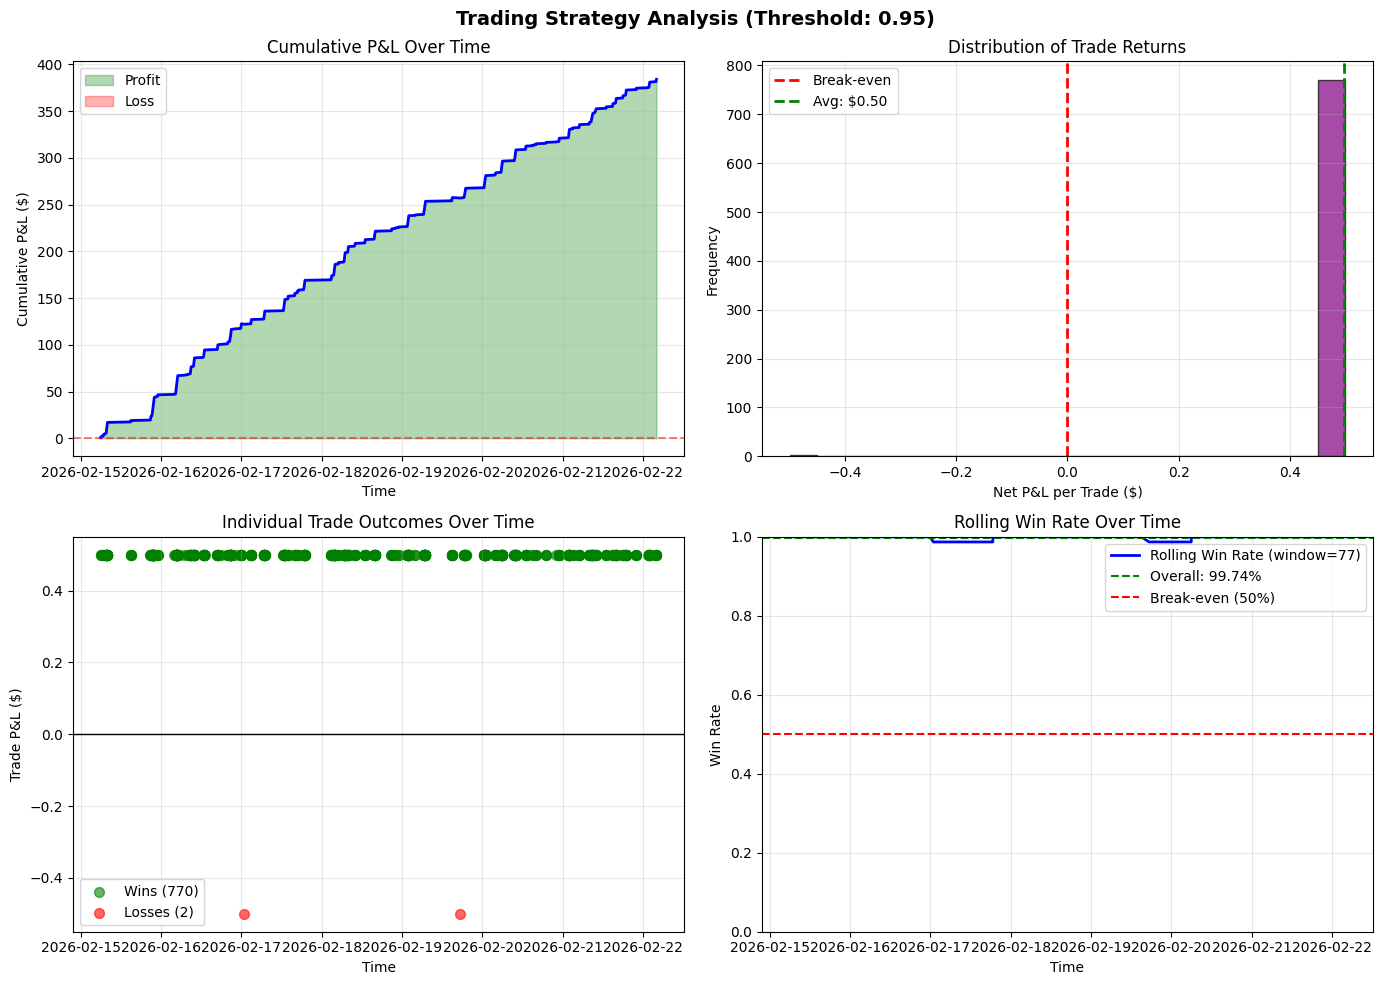


THRESHOLD SENSITIVITY ANALYSIS
 Threshold  Total_Trades  Win_Rate  Net_PnL       ROI
      0.50          4728  0.760152   1230.0 52.030457
      0.55          4074  0.791851   1189.0 58.370152
      0.60          3375  0.821926   1086.5 64.385185
      0.65          2819  0.858460   1010.5 71.692089
      0.70          2366  0.891801    927.0 78.360101
      0.75          1979  0.922688    836.5 84.537645
      0.80          1670  0.946108    745.0 89.221557
      0.85          1387  0.961067    639.5 92.213410
      0.90          1101  0.975477    523.5 95.095368
      0.95           772  0.997409    384.0 99.481865



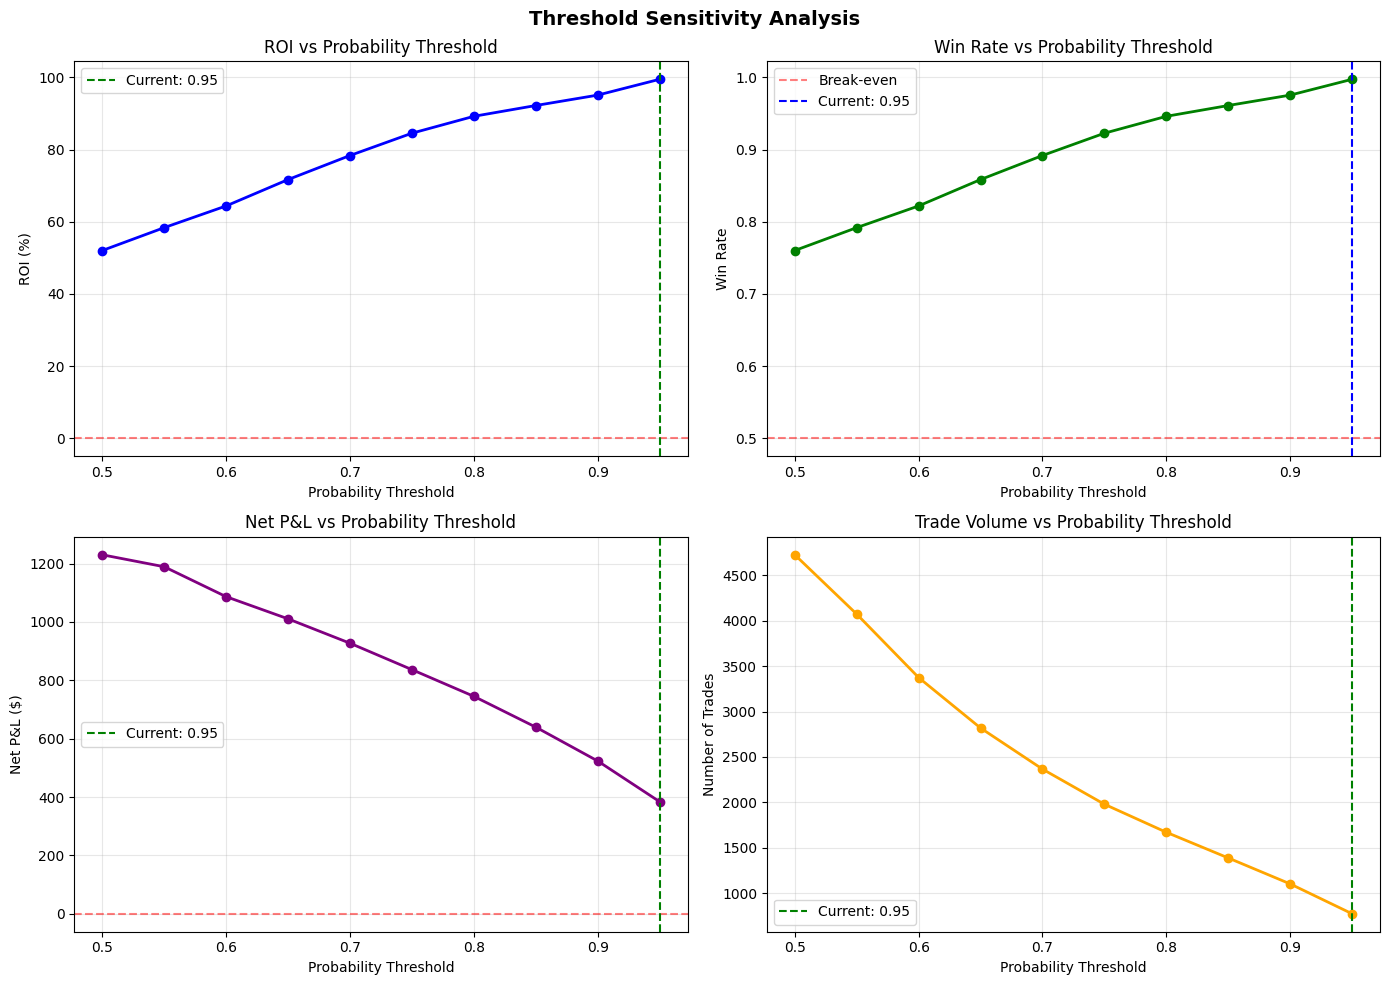

In [9]:
# ===== TRADING STRATEGY BACKTEST =====
# Filter trades where model probability exceeds threshold
trades = btc_data[btc_data["Prob_Up"] > TRADE_THRESHOLD].copy()

# Calculate P&L for each trade
# Win if actual went UP, lose otherwise
trades["Trade_Result"] = trades["Actual_Up"].apply(lambda x: WIN_AMOUNT if x == 1 else 0)
trades["Trade_Cost"] = COST_PER_TRADE
trades["Net_PnL"] = trades["Trade_Result"] - trades["Trade_Cost"]
trades["Cumulative_PnL"] = trades["Net_PnL"].cumsum()

# Calculate statistics
total_trades = len(trades)
winning_trades = trades["Actual_Up"].sum()
losing_trades = total_trades - winning_trades
win_rate = winning_trades / total_trades if total_trades > 0 else 0
total_pnl = trades["Net_PnL"].sum()
avg_pnl_per_trade = total_pnl / total_trades if total_trades > 0 else 0
roi = (total_pnl / (total_trades * COST_PER_TRADE)) * 100 if total_trades > 0 else 0

print(f"\n{'=' * 60}")
print(f"TRADING STRATEGY BACKTEST (Threshold: {TRADE_THRESHOLD})")
print(f"{'=' * 60}")
print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades} ({win_rate:.2%})")
print(f"Losing Trades: {losing_trades} ({(1 - win_rate):.2%})")
print("\nFinancial Performance:")
print(f"Total Cost: ${total_trades * COST_PER_TRADE:.2f}")
print(f"Total Revenue: ${winning_trades * WIN_AMOUNT:.2f}")
print(f"Net P&L: ${total_pnl:.2f}")
print(f"Average P&L per Trade: ${avg_pnl_per_trade:.2f}")
print(f"ROI: {roi:.2f}%")
print(f"{'=' * 60}\n")

# ===== VISUALIZATION =====
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(
    f"Trading Strategy Analysis (Threshold: {TRADE_THRESHOLD})", fontsize=14, fontweight="bold"
)

# Plot 1: Cumulative P&L over time
ax1 = axes[0, 0]
ax1.plot(trades.index, trades["Cumulative_PnL"], linewidth=2, color="blue")
ax1.axhline(y=0, color="red", linestyle="--", alpha=0.5)
ax1.fill_between(
    trades.index,
    trades["Cumulative_PnL"],
    0,
    where=(trades["Cumulative_PnL"] >= 0),
    alpha=0.3,
    color="green",
    label="Profit",
)
ax1.fill_between(
    trades.index,
    trades["Cumulative_PnL"],
    0,
    where=(trades["Cumulative_PnL"] < 0),
    alpha=0.3,
    color="red",
    label="Loss",
)
ax1.set_xlabel("Time")
ax1.set_ylabel("Cumulative P&L ($)")
ax1.set_title("Cumulative P&L Over Time")
ax1.legend()
ax1.grid(visible=True, alpha=0.3)

# Plot 2: Distribution of individual trade P&L
ax2 = axes[0, 1]
ax2.hist(trades["Net_PnL"], bins=20, alpha=0.7, edgecolor="black", color="purple")
ax2.axvline(x=0, color="red", linestyle="--", linewidth=2, label="Break-even")
ax2.axvline(
    x=avg_pnl_per_trade,
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Avg: ${avg_pnl_per_trade:.2f}",
)
ax2.set_xlabel("Net P&L per Trade ($)")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Trade Returns")
ax2.legend()
ax2.grid(visible=True, alpha=0.3)

# Plot 3: Win/Loss timeline
ax3 = axes[1, 0]
winning_mask = trades["Actual_Up"] == 1
ax3.scatter(
    trades[winning_mask].index,
    trades[winning_mask]["Net_PnL"],
    color="green",
    label=f"Wins ({winning_trades})",
    alpha=0.6,
    s=50,
)
ax3.scatter(
    trades[~winning_mask].index,
    trades[~winning_mask]["Net_PnL"],
    color="red",
    label=f"Losses ({losing_trades})",
    alpha=0.6,
    s=50,
)
ax3.axhline(y=0, color="black", linestyle="-", linewidth=1)
ax3.set_xlabel("Time")
ax3.set_ylabel("Trade P&L ($)")
ax3.set_title("Individual Trade Outcomes Over Time")
ax3.legend()
ax3.grid(visible=True, alpha=0.3)

# Plot 4: Rolling win rate
ax4 = axes[1, 1]
BATCH_SIZE = 10
window_size = max(BATCH_SIZE, total_trades // BATCH_SIZE) if total_trades >= BATCH_SIZE else total_trades  # noqa: E501
if total_trades > 0:
    rolling_win_rate = trades["Actual_Up"].rolling(window=window_size, min_periods=1).mean()
    ax4.plot(
        trades.index,
        rolling_win_rate,
        linewidth=2,
        color="blue",
        label=f"Rolling Win Rate (window={window_size})",
    )
    ax4.axhline(y=win_rate, color="green", linestyle="--", label=f"Overall: {win_rate:.2%}")
    ax4.axhline(y=0.5, color="red", linestyle="--", label="Break-even (50%)")
    ax4.set_xlabel("Time")
    ax4.set_ylabel("Win Rate")
    ax4.set_title("Rolling Win Rate Over Time")
    ax4.set_ylim([0, 1])
    ax4.legend()
    ax4.grid(visible=True, alpha=0.3)
else:
    ax4.text(
        0.5, 0.5, "No trades at this threshold", ha="center", va="center", transform=ax4.transAxes
    )
    ax4.set_title("Rolling Win Rate Over Time")

plt.tight_layout()
plt.show()

# ===== THRESHOLD SENSITIVITY ANALYSIS =====
# Test different thresholds to find optimal trading strategy
test_thresholds = np.arange(0.5, 1.0, 0.05)
results = []

for threshold in test_thresholds:
    test_trades = btc_data[btc_data["Prob_Up"] > threshold]

    if len(test_trades) > 0:
        wins = test_trades["Actual_Up"].sum()
        total = len(test_trades)
        win_rate = wins / total
        total_cost = total * COST_PER_TRADE
        total_revenue = wins * WIN_AMOUNT
        net_pnl = total_revenue - total_cost
        roi = (net_pnl / total_cost) * 100

        results.append(
            {
                "Threshold": threshold,
                "Total_Trades": total,
                "Win_Rate": win_rate,
                "Net_PnL": net_pnl,
                "ROI": roi,
            }
        )

results_df = pd.DataFrame(results)

# Display results table
print("\n" + "=" * 80)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80 + "\n")

# Visualization
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle("Threshold Sensitivity Analysis", fontsize=14, fontweight="bold")

# Plot 1: ROI vs Threshold
ax1 = axes2[0, 0]
ax1.plot(results_df["Threshold"], results_df["ROI"], marker="o", linewidth=2, color="blue")
ax1.axhline(y=0, color="red", linestyle="--", alpha=0.5)
ax1.axvline(x=TRADE_THRESHOLD, color="green", linestyle="--", label=f"Current: {TRADE_THRESHOLD}")
ax1.set_xlabel("Probability Threshold")
ax1.set_ylabel("ROI (%)")
ax1.set_title("ROI vs Probability Threshold")
ax1.legend()
ax1.grid(visible=True, alpha=0.3)

# Plot 2: Win Rate vs Threshold
ax2 = axes2[0, 1]
ax2.plot(results_df["Threshold"], results_df["Win_Rate"], marker="o", linewidth=2, color="green")
ax2.axhline(y=0.5, color="red", linestyle="--", alpha=0.5, label="Break-even")
ax2.axvline(x=TRADE_THRESHOLD, color="blue", linestyle="--", label=f"Current: {TRADE_THRESHOLD}")
ax2.set_xlabel("Probability Threshold")
ax2.set_ylabel("Win Rate")
ax2.set_title("Win Rate vs Probability Threshold")
ax2.legend()
ax2.grid(visible=True, alpha=0.3)

# Plot 3: Net P&L vs Threshold
ax3 = axes2[1, 0]
ax3.plot(results_df["Threshold"], results_df["Net_PnL"], marker="o", linewidth=2, color="purple")
ax3.axhline(y=0, color="red", linestyle="--", alpha=0.5)
ax3.axvline(x=TRADE_THRESHOLD, color="green", linestyle="--", label=f"Current: {TRADE_THRESHOLD}")
ax3.set_xlabel("Probability Threshold")
ax3.set_ylabel("Net P&L ($)")
ax3.set_title("Net P&L vs Probability Threshold")
ax3.legend()
ax3.grid(visible=True, alpha=0.3)

# Plot 4: Number of Trades vs Threshold
ax4 = axes2[1, 1]
ax4.plot(
    results_df["Threshold"], results_df["Total_Trades"], marker="o", linewidth=2, color="orange"
)
ax4.axvline(x=TRADE_THRESHOLD, color="green", linestyle="--", label=f"Current: {TRADE_THRESHOLD}")
ax4.set_xlabel("Probability Threshold")
ax4.set_ylabel("Number of Trades")
ax4.set_title("Trade Volume vs Probability Threshold")
ax4.legend()
ax4.grid(visible=True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Find optimal threshold
if len(results_df) > 0:
    best_roi_idx = results_df["ROI"].idxmax()
    best_pnl_idx = results_df["Net_PnL"].idxmax()

    print("\nOptimal Thresholds:")
    print(
        f"Best ROI: {results_df.loc[best_roi_idx, 'Threshold']:.2f} "
        f"(ROI: {results_df.loc[best_roi_idx, 'ROI']:.2f}%, "
        f"Trades: {results_df.loc[best_roi_idx, 'Total_Trades']:.0f})"
    )
    print(
        f"Best Net P&L: {results_df.loc[best_pnl_idx, 'Threshold']:.2f} "
        f"(P&L: ${results_df.loc[best_pnl_idx, 'Net_PnL']:.2f}, "
        f"Trades: {results_df.loc[best_pnl_idx, 'Total_Trades']:.0f})"
    )


Optimal Thresholds:
Best ROI: 0.95 (ROI: 99.48%, Trades: 772)
Best Net P&L: 0.50 (P&L: $1230.00, Trades: 4728)
